# Visualising sequence diversity of secreted signal peptides of the Bacillus taxonomy through tSNE bio-informatic analysis

*This notebook aims to provide a procedure for visualising the sequence diversity of secreted signal peptides using a t-distributed stochastic neighbor embedding (tSNE) manifold learning approach. tSNE is a common data analysis pipeline used in bioinformatics and has had successfull results in researching deep sequencing. This method has now been adapted to visualise sequence diversity. Through the formation of 2D or 3D clusters, we  aim to identify distinctions in the different sets of signal peptide sequences through this approach. Provided below is a full procedure starting from characterisation and processing to PAM distances and visualisation. Included here is the code necessary to conduct this analysis. We apply this approach to the Bacillus genus, the primary focus of this project.*

## 1. Characterisation and Processing of Bacillus genus
## 1.1 Advanced search with UniprotKB

An advanced search on the UniprotKB database was done to characterise all amino acid sequences of secreted signal peptides (SP's) pertaining to the Bacillus genome. This was done with the following as input: `locations:(location:"Secreted [SL-0243]") annotation:(type:signal) taxonomy:"Bacillus [1386]".`

6889 sequences were collected from this advanced search. All entries were then downloaded as a compressed Fasta (canonical) file from the UniprotKB database. Using the `pyfasta` package, the fasta file was divided into two sets of seperate fasta files containing 3319 (`uniprot0.fasta`) and 3570 sequences (`uniprot1.fasta`) respectively. We use the `split` command as follows through the cmd `shell` as `pyfasta split -n 2 input.fasta`. 

## 1.2 SignalP 5.0 Cleavage Site Prediction
These variety of SP sequences were then input into SignalP 5.0 with input as `organism: Eukarya, output: long format` for a prediction of their cleavage sites. After propogation, results were downloaded as a `JSON` summary, processed `gff3` summary, processed `FASTA` entries, prediction summary and as an overall `zip` file. This was done for the `FASTA` files outlined above obtained from the UniprotKB database. 

## 1.3 `gff3` and `FASTA` Extraction
The processed `gff3` files that contained the predicted cleavage site of SP's were then transformed to a 5+ post-cleavage prediction. (**WHY??**). We use the following command with `awk`.

`awk  '{$5=$5+5; print $0}' OFS='\t' yourfile.gtf > outputfile.txt`
 - `yourfile.gtf` refers to the `.gff3` file taken from SignalP. Replace this with `/path/to/yourfile.gff3`. Note: In later formats `.gtf` is equivalent to `.gff3`.
 - `outputfile.txt` refers to the file with the +5 post predicted cleavage sites. Create an `name_output.gff3` using `touch` and then replace with `/path/to/name_output.gff3`.

These converted `gff3` were then used to extract the `fasta` files of the processed SP's as they contained the corresponding sequence sets needed. We use the BEDTools2 suite for the extraction of these `fasta` files. Installation procedures are found here: https://software.broadinstitute.org/software/igv/installbedtools. Once installed, the following command was used for extraction. The command-line interface is described below:

`bedtools getfasta -fi <input FASTA> -bed <BED/GFF/VCF> -fo <output FASTA>`

 - `<input FASTA>` corresponds to the raw `fasta` files containing the processed SP's from SignalP. Replace with `/path/to/input.fasta`
 - `<BED/GFF?VCF>` corresponds to the sequence set to be extracted from `<input FASTA>`. Replace with `/path/to/outputfile.gff3`.
 - `<output FASTA>` corresponds to the extracted `fasta` output file from `<input FASTA>` and the processed `gff3` entries. Replace with `/path/to/output.fasta`. Create `output.fasta` file using `touch` in cmd-line.
 - Execute command in `/path/to/bedtools_installation/bin` directory with `./command`.
 
Once extracted, given in the beginning the `FASTA` files were split into two, the separate extracted `FASTA` files were combined back together for MAFFT sequence alignment. This was done as follows.

`cat name_output1.fasta name_output2.fasta > name_combined_output.fasta`

## 2. Pairwise Distance Calculation
## 2.1 MAFFT Sequence Alignment
Extracted `FASTA` files were then put into a MAFFT (Multiple Alignment using Fast Fourier Transform) to align the sequences. This was done with the MAFFT online service, with input as the combined `FASTA` output file outlined above and with all settings as default. The result of SP sequence alignment was then downloaded as a `FASTA` file as the input to computing the pairwise distance.

## 2.2 MEGA11 Pairwise Distance Computation
MEGA11 Software was downloaded as a GUI interface. This was used to calculate the pairwise distance and generate a pairwise distance matrix under the Dayhoff Model. We use the Dayhoff Model since the model decreased the scaterredness of the calculations, making it more suitable for a t-SNE analysis conducted later.
 - **Computer Pairwise Distance > Select `fasta` input > Select Pairwise Distance > Lower Left Matrix > Analysis Preferences > Select Dayhoff Model > OK**

The output was then downloaded as a MEGA `.txt` file and then converted into a `.csv`. This was done so that there was no size restriction on the output distance matrix. The code for this is written by Oliver Smith. This is shown below, with slight modifications.

In [ ]:
"""
Converts a MEGA11 text file to a CSV file.
Saves as a complete matrix with 0-distance identity diagonal and with %8f precision.
NOTE: Do not run this code in the Notebook as it does not contain the fasta input.
"""

args_input = "name_of_mega11_file.txt"
args_output = "output_megatocsv.csv"

def megatocsv(args_input, args_output):
    names = []
    rows = []
    seen_names = False
    seen_data = False
    with open(args_input, 'rt') as f:
        for line in f:
            if seen_names and seen_data:
                if len(line.strip()) == 0:
                    # empty line after data matrix
                    break  # we're done!
                # collect data and when done, finish up
                # separate sample names see if we're past the column headers
                name_cols = line.split(']')[0].replace('[','').strip().split()
                if len(name_cols) > 1:
                    continue  # skip the column header row
                data_cols = line.split(']')[1].strip().split()
                data_cols.append('')
                rows.append(data_cols)
                continue
            if not seen_names and not line.startswith('['):
                continue
            if not seen_names and line.startswith('['):
                seen_names = True
            if seen_names and not seen_data:
                if len(line.strip()) == 0:
                    # empty line after name section!
                    seen_data = True
                    continue
                name = line.split('#',1)[1].strip()
                names.append(name)

    with open(args_output, 'wt') as outf:
        outline = ',' + ','.join(names)
        print(outline, file=outf)
        for i, row in enumerate(rows):
            outline = names[i] + ',' + ','.join(row)
            print(outline, file=outf)

# Grab output
megatocsv(args_input, args_output)

## 3. Visualisation using Manifold learning and t-SNE analysis
We implement a truncated SVD (singular value decomposition) followed by a t-SNE (t-distributed stochastic neighbour) to visualise the SP's in relation to each other and to ideally obtain distinct clusters through application of these models to our distance matrix. This process is show below and is done with a sample matrix of reviewed sequences of the Bacillus taxonomy (with 113 sequences) for simplicity. All of the code below is written by Oliver Smith, with slight modifications and added comments for clarity.

## 3.1 Conversion of LT distance matrix to square matrix
We convert from a lower triangular distance matrix to a full square matrix for SVD (as eigendecomposition is limited to square-only). The following code illustrates how to do so. 

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import plotly.express as px
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from scipy.sparse.linalg import svds
from functools import partial

We first establish the distance matrix as a `dataframe (df)`, using the 0th column as the `df` names. We then check that the dataframe has been established and call the default `head` method to see the first 5 entries.

In [2]:
distance_matrix = pd.read_csv("sample_distancematrix.csv", index_col=0)
# Check that df has been established
type(distance_matrix)
distance_matrix.head()

,sp_P40136_CYAA_BACAN:0-33,sp_P21130_SACB_BACAM:0-34,sp_P05655_SACB_BACSU:0-34,sp_P13423_PAG_BACAN:0-25,sp_P39848_LYTD_BACSU:0-32,sp_Q02114_LYTC_BACSU:0-29,sp_P80172_HBLA_BACCE:0-26,sp_P42111_YXAL_BACSU:0-29,sp_P54507_TASA_BACSU:0-32,sp_P55278_MANB_BACIU:0-29,...,sp_O31097_PHYC_BACIU:0-31,sp_P42094_PHYT_BACSU:0-31,sp_P05656_SACC_BACSU:0-29,sp_P06278_AMY_BACLI:0-34,sp_P00692_AMY_BACAM:0-36,sp_P19571_AMT6_BACS7:0-38,sp_O31526_YESW_BACSU:0-40,sp_P54422_GGT_BACSU:0-33,sp_P63186_GGT_BACNA:0-33,sp_P42983_NUCB_BACSU:0-31
sp_P40136_CYAA_BACAN:0-33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sp_P21130_SACB_BACAM:0-34,2.317421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sp_P05655_SACB_BACSU:0-34,2.188216,0.147131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sp_P13423_PAG_BACAN:0-25,5.900376,4.178429,5.105374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sp_P39848_LYTD_BACSU:0-32,3.187045,3.566499,2.862577,7.745792,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We then convert the distance matrix into a `numpy` array. This is because they are more optimised and are easier to use when under SVD/t-SNE analysis. We replace the `?` and `nan` entries of the `distance_matrix (dm)` with the `numpy` equivalent, `np.nan` and then update the main diagonal of the matrix to be all zeroes.

In [59]:
dm = distance_matrix
dm = dm.replace('?', np.nan)
dm = dm.replace('nan', np.nan)
dm = np.array(dm, dtype=np.double)
np.fill_diagonal(dm, np.double(0))
dm.shape

(113, 113)

We convert the current `distance_matrix`, a lower triangular matrix, to be a square matrix by essentially mirroring the lower triangular entries across the main diagonal that is filled with zeroes. This is done by asserting the `isnan` condition onto the matrix.

In [60]:
inds = np.where(np.isnan(dm))
for row,col in zip(inds[0],inds[1]):
    if not np.isnan(dm[col,row]):
        dm[row,col] = dm[col,row]
        
#print(inds[0], inds[1])
#print(dm[10])

We then replace missing values in the matrix with 0. This allows us to perform an expectation maximisation 
algorithm such that when we apply t-SNE we can get more distinct clusters. Missing values would ideally be replaced by a model or search that could take in adjacent values and calculate the best estimate. Then, we update the `df` by adding the rows and columns to the dataset as the  values of the indexes and columns from the original distance matrix. Repeat check that the `df` has been established and call `head`.

In [61]:
inds = np.where(np.isnan(dm))
for i, (row, col) in enumerate(zip(inds[0], inds[1])):
    dm[row,col] = np.double(0)
    
dm2 = pd.DataFrame(data=dm, index=distance_matrix.index.values, columns=distance_matrix.columns.values)

type(dm2)
dm2.head()

,sp_P40136_CYAA_BACAN:0-33,sp_P21130_SACB_BACAM:0-34,sp_P05655_SACB_BACSU:0-34,sp_P13423_PAG_BACAN:0-25,sp_P39848_LYTD_BACSU:0-32,sp_Q02114_LYTC_BACSU:0-29,sp_P80172_HBLA_BACCE:0-26,sp_P42111_YXAL_BACSU:0-29,sp_P54507_TASA_BACSU:0-32,sp_P55278_MANB_BACIU:0-29,...,sp_O31097_PHYC_BACIU:0-31,sp_P42094_PHYT_BACSU:0-31,sp_P05656_SACC_BACSU:0-29,sp_P06278_AMY_BACLI:0-34,sp_P00692_AMY_BACAM:0-36,sp_P19571_AMT6_BACS7:0-38,sp_O31526_YESW_BACSU:0-40,sp_P54422_GGT_BACSU:0-33,sp_P63186_GGT_BACNA:0-33,sp_P42983_NUCB_BACSU:0-31
sp_P40136_CYAA_BACAN:0-33,0.000000,2.317421,2.188216,5.900376,3.187045,2.134463,2.753953,7.176877,4.829661,7.856491,...,1.620990,2.510162,1.179514,53.652969,52.745164,53.329844,50.706240,3.714513,3.463632,4.275441
sp_P21130_SACB_BACAM:0-34,2.317421,0.000000,0.147131,4.178429,3.566499,2.185370,44.018959,38.817980,8.431565,6.234329,...,4.485779,9.769631,2.937044,50.319249,48.956656,49.100947,45.714417,4.449110,4.463927,2.878167
sp_P05655_SACB_BACSU:0-34,2.188216,0.147131,0.000000,5.105374,2.862577,2.017437,43.985606,39.767671,8.411944,7.485056,...,4.396860,8.238085,3.221941,48.857431,46.744581,47.012263,44.749592,5.067732,5.106598,2.601913
sp_P13423_PAG_BACAN:0-25,5.900376,4.178429,5.105374,0.000000,7.745792,3.058221,5.141543,3.105309,3.692654,2.077945,...,6.881202,7.984787,52.259433,3.888638,3.104124,3.047514,9.577735,11.049531,11.331024,44.312276
sp_P39848_LYTD_BACSU:0-32,3.187045,3.566499,2.862577,7.745792,0.000000,3.027406,3.949565,3.109435,2.396294,39.035636,...,10.723750,42.284157,6.344020,51.055230,50.336309,3.691861,41.588930,6.186906,6.201986,2.450963


## 3.2 Define SVD and t-SNE
Here, we define our variables for truncated SVD and t-SNE. We set the dimensionality of the dataset `num_TSNE` to three  based off the common data analysis convention (**though two would also suffice ... also, Barnes-hut algorithm???**). We use a `precomputed` metric, which assumes that the dataset is a distance matrix. We also use `random_state=0` for standardisation purposes for both `tSNE` and `svd`. This leads to implementing truncated SVD (`svd`) with `n=12` components, `n=13` iterations and a standardised 0 `random_state`, with all other parameters unchanged. Likewise, we implement `tSNE` similarly but with `n=3` components, the `precomputed` metric and the same `random_state`, with all other parameters unchanged.

In [62]:
num_TSNE=3
metric = "precomputed"
state = 0
tSNE = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
svd = TruncatedSVD(n_components=12, n_iter=13, random_state=state)

`svd`, followed up by `tSNE` is run. We adapt this method from the source: https://github.com/scikit-learn/scikit-learn/issues/17916. Although the `svd` implementation is unchanged, we increase the iterations of our `tSNE` to `n=250` and also change `perplexity=75`. The `perplexity` parameter changes the number of neighbours obtained from `tSNE` (`default=30`). Note that changing the following parameters is allowed and could provide different results. `svd` parameters can be changed in the `svd` assignment. 

Once the pipeline is made from the estimators, we fit the `tSNE` to our embedded space distance matrix `dm2` and return with the transformed output `wide_tSNE`.

In [63]:
tSNE = make_pipeline(svd, TSNE(n_iter=250, n_components=num_TSNE, random_state=state, perplexity=75))

wide_tSNE = tSNE.fit_transform(dm2)

#print(wide_tSNE)
wide_tSNE.shape

/Users/pranav/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/pranav/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(113, 3)

## 3.3 2D tSNE Visualisation
To visualise our data, we first construct a tSNE dataframe (`tSNE_df`) as follows. We first initialise 3 columns of the `tSNE_df` as `TSNE1`, `TSNE2`, and `TNSE3`, which will contain the 3 tSNE features for all SP sequences. The `tSNE_df` will initially contain only the `wide_tSNE` values, and no index. This is followed up by adding the index to the `tSNE_df`.

We first create a new, empty dataframe only containing the SP names as the index from the original `distance_matrix` and then initialise it to be the index of `tSNE_df`. Once the dataframe has been generated, we save the tSNE values as a `.csv` without the index.

In [64]:
# Initialise columns for tSNE
tSNE_df = pd.DataFrame({'tSNE_x': wide_tSNE[:,0], 'tSNE_y': wide_tSNE[:,1],'tSNE_z': wide_tSNE[:,2]})
# Create new dataframe for index and initialse as tSNE_df index
df_index = pd.DataFrame(index = distance_matrix.index)
tSNE_df.index = df_index.index
# Save tSNE values without index
tSNE_df.to_csv('tSNE_final.csv', index=False)

tSNE_df.head()

,tSNE_x,tSNE_y,tSNE_z
sp_P40136_CYAA_BACAN:0-33,22.134161,-16.489908,70.244385
sp_P21130_SACB_BACAM:0-34,0.812456,-0.592489,1.193235
sp_P05655_SACB_BACSU:0-34,-1.183740,13.923452,12.961679
sp_P13423_PAG_BACAN:0-25,17.319683,23.613356,-56.356293
sp_P39848_LYTD_BACSU:0-32,0.544308,-0.192222,-15.980375


As `num_tSNE` had 3 dimensions that were defined, we plot each plane (x-y, x-z, and y-z) separately as follows. `Graph 1` shows the x-y plane, `Graph 2` shows the x-z plane, and `Graph 3` shows the y-z plane.

In [65]:
fig1 = px.scatter(tSNE_df, x='tSNE_x', y='tSNE_y', hover_name=tSNE_df.index, template='ggplot2', opacity=1, title='Graph 1: tSNE Visualisation in the x-y plane')
fig1

In [66]:
fig2 = px.scatter(tSNE_df, x='tSNE_x', y='tSNE_z', hover_name=tSNE_df.index, template='ggplot2', opacity=1, title='Graph 2: tSNE Visualisation in the x-z plane')
fig2

In [67]:
fig3 = px.scatter(tSNE_df, x='tSNE_y', y='tSNE_z', hover_name=tSNE_df.index, template='ggplot2', opacity=1, title='Graph 3: tSNE Visualisation in the y-z plane')
fig3

The following is a side-by-side visualisation of the above graphs in order of the x-y plane (leftmost), x-z plane (central), and the y-z plane (rightmost). 

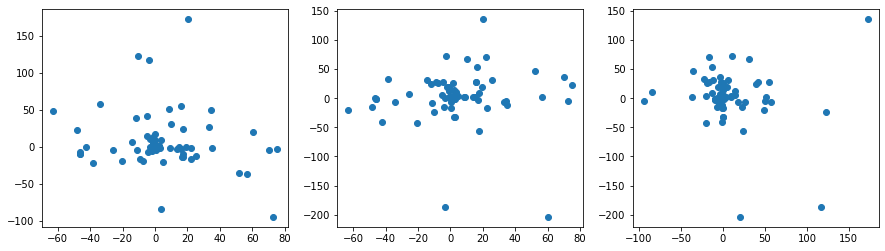

In [104]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(131)
ax1.scatter(wide_tSNE[:,0], wide_tSNE[:,1])
ax2 = fig.add_subplot(132)
ax2.scatter(wide_tSNE[:,0], wide_tSNE[:,2])
ax3 = fig.add_subplot(133)
ax3.scatter(wide_tSNE[:,1], wide_tSNE[:,2])
plt.show()

## 3.4 3D tSNE Visualisation
Finally, we combine all the above results and generate a 3D visualisation of the tSNE manifold learning approach with respect to sequence diversty of the Bacillus taxonomy.

In [98]:
fig = px.scatter_3d(tSNE_df, x='tSNE_x', y='tSNE_y', z='tSNE_z',
                    hover_name=tSNE_df.index, template='ggplot2', opacity=1, 
                    title='Visualising sequence diversity of Bacillus taxonomy using tSNE manifold learning (PAM distance embedded)',
                    labels={'tSNE_x': 'X', 'tSNE_y': 'Y', 'tSNE_z':'Z'}, )

# Write the figure to a HTML representation and download for later
fig.write_html('scatter-3d.html')
fig

# 4 Bibliography & Acknowledgements

I would like to give acknowledgement to Dr. Joseph Brock for providing me the opportunity to undertake this research. I would also like to give a huge thanks to Oliver Smith for not only providing his code (which can be found below), but also the process and approach needed for this result. Credits go to the RSB and PhB conveners for the approval of this project.

 - https://colab.research.google.com/drive/11dtzeOKwHf9RUoKxp00YVM0N9VDgfiqm?usp=sharing#scrollTo=Sg5T91_TwxBY
 - https://colab.research.google.com/drive/1dXU8pyD-2nWsJk3pmPwlLp9jb4e4HwTQ
 - https://www.uniprot.org/uniprot/?query=locations%3A%28location%3A%22Secreted+%5BSL-0243%5D%22%29+annotation%3A%28type%3Asignal%29+taxonomy%3A%22Bacillus+%5B1386%5D%22&sort=score
 - https://services.healthtech.dtu.dk/service.php?SignalP-5.0
 - https://mafft.cbrc.jp/alignment/server/
 - https://www.megasoftware.net